In [22]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
import matplotlib.pyplot as plt
from datetime import datetime
import math
from convlstm import ConvLSTM
from video_dataset import VideoFrameDataset
from rrunet import RR_UNET

In [45]:
transform = transforms.Compose([
    transforms.Pad(padding=(0, 40), padding_mode='edge'),  # Only pad width
    # transforms.Resize((256, 256)),  # Resize the now square image to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5002, 0.4976, 0.4945], std=[0.0555, 0.0547, 0.0566])  # Standard normalization
])

root_dir = '/home/yibin/workspace/dl/final_completion/dataset_student/dataset'  # Change this to the path of the dataset
train_set = VideoFrameDataset(root_dir, 'train', transform)
val_set = VideoFrameDataset(root_dir, 'val', transform)
unlabeled_set = VideoFrameDataset(root_dir, 'unlabeled', transform)
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [46]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
model = RR_UNET(3, 49).to(device)

In [5]:
video, _, _, _,_, _ = next(iter(train_loader))
video = video.to(device).squeeze(0)
print(video.shape)
output = model(video)
print(output.shape)

torch.Size([22, 3, 240, 240])
torch.Size([22, 49, 160, 240])


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

In [7]:
now = datetime.now()
formatted_time = now.strftime("%m_%d_%Y_%H%M%S")
dir_name = f'rrunet_seg_model-{formatted_time}'
os.makedirs(dir_name, exist_ok=True)
model.to(device)
train_loss, valid_loss = [], []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for videos, _, _, masks, _ in train_loader:
        videos = videos.to(device).squeeze(0)
        masks = masks.to(device, dtype=torch.long).squeeze(0)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, masks)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_epoch_loss = running_loss / len(train_loader)
    train_loss.append(train_epoch_loss)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for videos, _, _, masks, _ in val_loader:
            videos = videos.to(device).squeeze(0)
            masks = masks.to(device, dtype=torch.long).squeeze(0)
            outputs = model(videos)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    val_epoch_loss = val_loss / len(val_loader)
    valid_loss.append(val_epoch_loss)

    if epoch % 10 == 0:
        path = f'{dir_name}/rrunet_seg_model_epoch_{epoch+1}.pt'
        torch.save(model, path)
        print(f'Epoch {epoch+1}, Train Loss: {train_epoch_loss}, Val Loss: {val_epoch_loss}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.30600243915617464, Val Loss: 0.169220966771245
Epoch 11, Train Loss: 0.01651665181759745, Val Loss: 0.01853917362075299
Epoch 21, Train Loss: 0.0075149390946608035, Val Loss: 0.016584063952788712
Epoch 31, Train Loss: 0.006458422113908455, Val Loss: 0.03538231031037867
Epoch 41, Train Loss: 0.0068522864494007085, Val Loss: 0.01209743801713921
Epoch 51, Train Loss: 0.0046571341379312795, Val Loss: 0.010068349561654031
Epoch 61, Train Loss: 0.004278991126455366, Val Loss: 0.04003629911132157
Epoch 71, Train Loss: 0.003781920461799018, Val Loss: 0.008749981486005708
Epoch 81, Train Loss: 0.0036576152080669997, Val Loss: 0.01067286890745163
Epoch 91, Train Loss: 0.003245143134263344, Val Loss: 0.03423524618707597


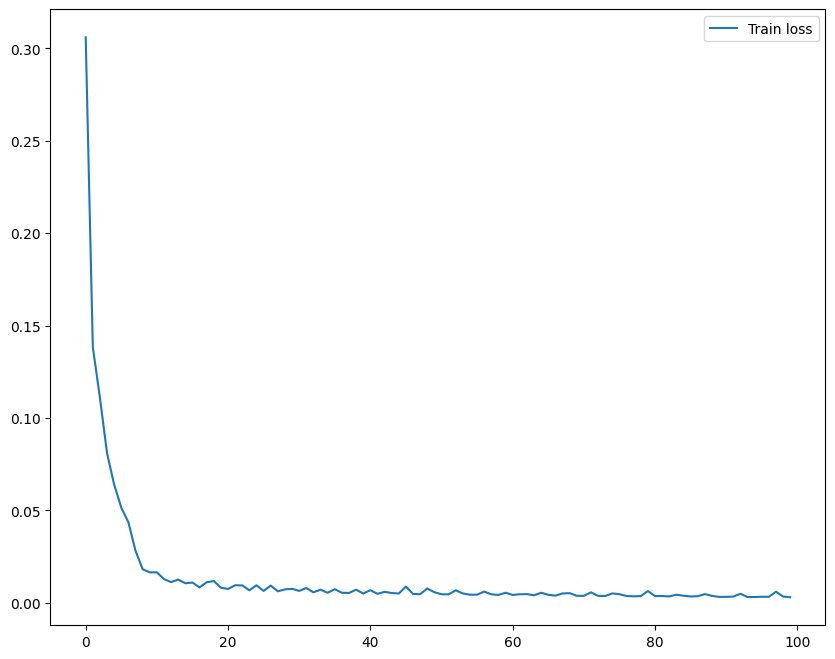

In [8]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.legend()
plt.show()

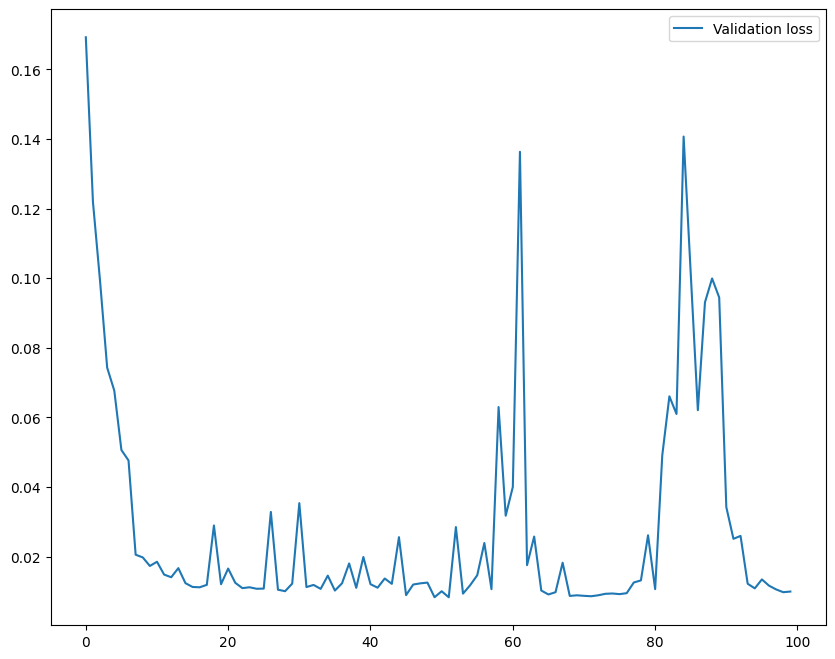

In [9]:
plt.figure(figsize=(10,8))
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

In [10]:
path = dir_name + f'/checkpoint.pt'
torch.save(model, path)

### Test Code for Image Segmentation Model

In [48]:
model = RR_UNET(3, 49)
model = torch.load("/home/yibin/workspace/dl/final_completion/rrunet_seg_model-04_24_2024_222829/checkpoint.pt") # model path
model.to(device)

RR_UNET(
  (conv1): RRR_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (conv1): ResBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [49]:
sample_output_list = []
sample_mask_truth_list = []
model.eval()
with torch.no_grad():
    for videos, _, _, masks, _ , _ in val_loader:
        videos = videos.to(device).squeeze(0)
        masks = masks.squeeze(0)
        outputs = model(videos)
        outputs = torch.argmax(outputs, dim=1)
        sample_output_list.append(outputs.cpu())
        sample_mask_truth_list.append(masks)
sample_all_outputs = torch.cat(sample_output_list, dim=0)
sample_all_truth = torch.cat(sample_mask_truth_list, dim=0)

In [50]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task="multiclass", num_classes=49)
jaccard(sample_all_outputs, sample_all_truth)

tensor(0.9334)

In [60]:
num = 21

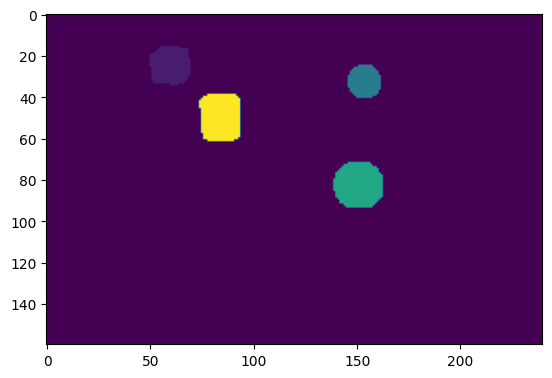

In [61]:
# predicted mask
plt.imshow(sample_all_outputs[num].cpu().numpy())

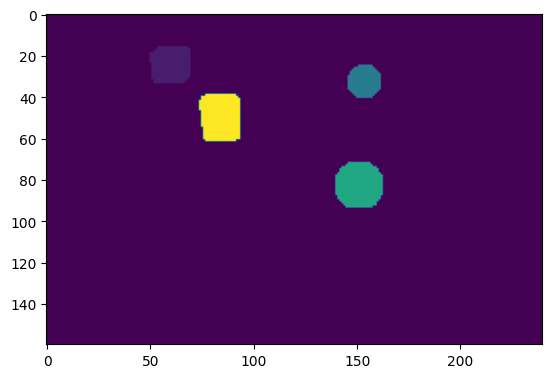

In [62]:
# ground truth mask
plt.imshow(sample_all_truth[num].cpu().numpy())

In [54]:
truth_image = []
for videos, _, _, masks, _ , _ in val_loader:
    videos = videos.to(device).squeeze(0)
    truth_image.append(videos)
    break

In [55]:
def imshow(tensor):
    # Assuming tensor is normalized in the typical range for pretrained models
    mean = torch.tensor([0.5002, 0.4976, 0.4945])
    std = torch.tensor([0.0555, 0.0547, 0.05665])

    # Denormalize the image
    tensor = tensor.clone()  # Clone the tensor so not to do changes on the original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and then add the mean

    # Convert tensor to image
    image = tensor.permute(1, 2, 0)  # Change from CxHxW to HxWxC format
    image = image.numpy()  # Convert to numpy array

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # No axis to show
    plt.show()

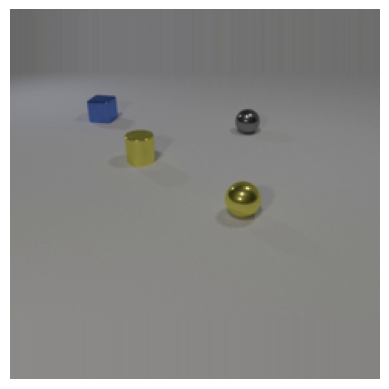

In [59]:
imshow(truth_image[0][21].cpu())